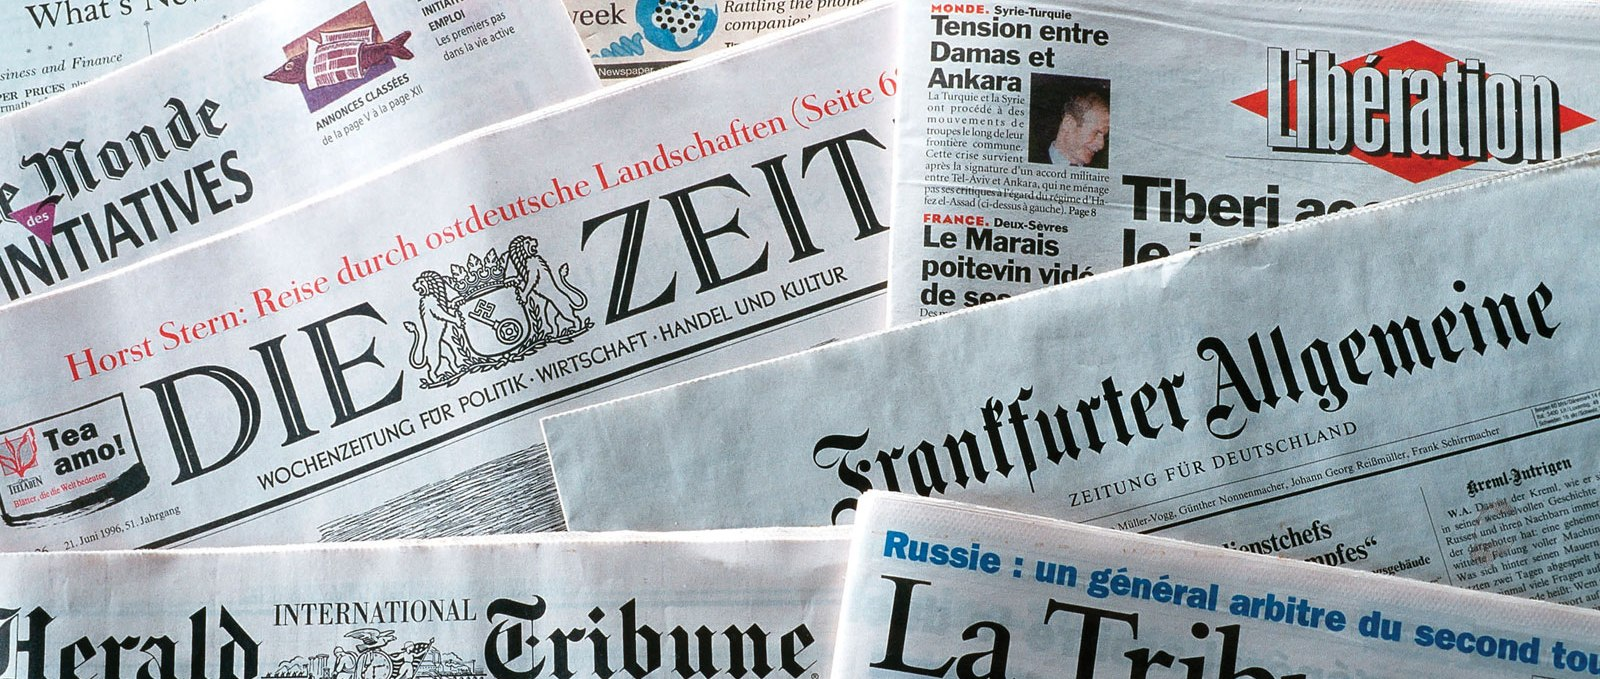

# Fake News

### Intro
* lable == 1: unreliable
* label == 0: reliable

***
## My Workflow

#### 1. Import & Install libray
* Import Basic libray
* Import Enginnering libray

#### 2. Check out my data
* Check Shape / Info / Describe

#### 3. Exploratory Data Analysis(EDA) with Visualization [Before Preprocessing]
* Label Percent
* Text length / Word length per Label Percent

#### 4. Preprocessing Data
* Null value processing
* Drop columns

#### 5. Feature Engineering
* Concat "author" & "text" Columns
* Nomalization
* Plot WordClouds
* Words Tokenization
* Split Train / Test / Validation Data

#### 6. Modeling
* LSTM Modeling
* Bert Modeling

#### 7. Submission
* Submit the predictions
<br/><br/>
***

# 1. Import & Install libray
* Import Basic libray
* Import Enginnering libray

In [2]:
import re
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau



from sklearn.model_selection import train_test_split

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from wordcloud import WordCloud

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno


plt.style.use('seaborn')
sns.set(font_scale=2.5)
%matplotlib inline

In [3]:
# !python --version

In [4]:
# !pip list | grep tensorflow

In [5]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [6]:
train_df = pd.read_csv('/kaggle/input/fake-news/train.csv')
# test_df = pd.read_csv('/kaggle/input/fake-news/test.csv')
train_df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


# 2. Check out my data
* Check Shape / Info / Describe

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


In [8]:
train_df.describe()

,id,label
count,20800.000000,20800.000000
mean,10399.500000,0.500625
std,6004.587135,0.500012
min,0.000000,0.000000
25%,5199.750000,0.000000
50%,10399.500000,1.000000
75%,15599.250000,1.000000
max,20799.000000,1.000000


In [9]:
print("[title] ",train_df['title'][0])
print("[title] ",train_df['text'][0])

[title]  House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It
[title]  House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It By Darrell Lucus on October 30, 2016 Subscribe Jason Chaffetz on the stump in American Fork, Utah ( image courtesy Michael Jolley, available under a Creative Commons-BY license) 
With apologies to Keith Olbermann, there is no doubt who the Worst Person in The World is this week–FBI Director James Comey. But according to a House Democratic aide, it looks like we also know who the second-worst person is as well. It turns out that when Comey sent his now-infamous letter announcing that the FBI was looking into emails that may be related to Hillary Clinton’s email server, the ranking Democrats on the relevant committees didn’t hear about it from Comey. They found out via a tweet from one of the Republican committee chairmen. 
As we now know, Comey notified the Republican chairmen and Democratic ranking members 

# 3. Exploratory Data Analysis(EDA) with Visualization [Before Preprocessing]
* Label Percent
* Text length / Word length per Label Percent

In [10]:
train_df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


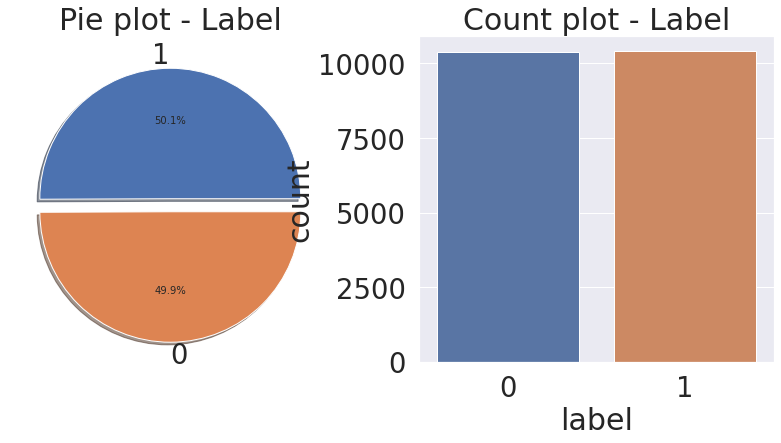

In [11]:
f,ax = plt.subplots(1,2,figsize=(14,6))
train_df['label'].value_counts().plot.pie(explode=[0, 0.1],autopct='%1.1f%%', ax=ax[0], shadow=True)
ax[0].set_title('Pie plot - Label')
ax[0].set_ylabel('')
sns.countplot('label', data = train_df, ax=ax[1])
ax[1].set_title('Count plot - Label')
plt.show()

In [12]:
def get_length_alphabets(text):
    text = str(text)
    return len(text)

In [13]:
def get_length_words(text):
    text = str(text)
    return len(text.split(' '))

In [14]:
train_df['length_alphabets'] = train_df['text'].apply(get_length_alphabets)
train_df['length_words'] = train_df['text'].apply(get_length_words)

In [15]:
train_df.head()

,id,title,author,text,label,length_alphabets,length_words
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,4930,820
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,4160,727
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,7692,1266
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,3237,559
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,938,154


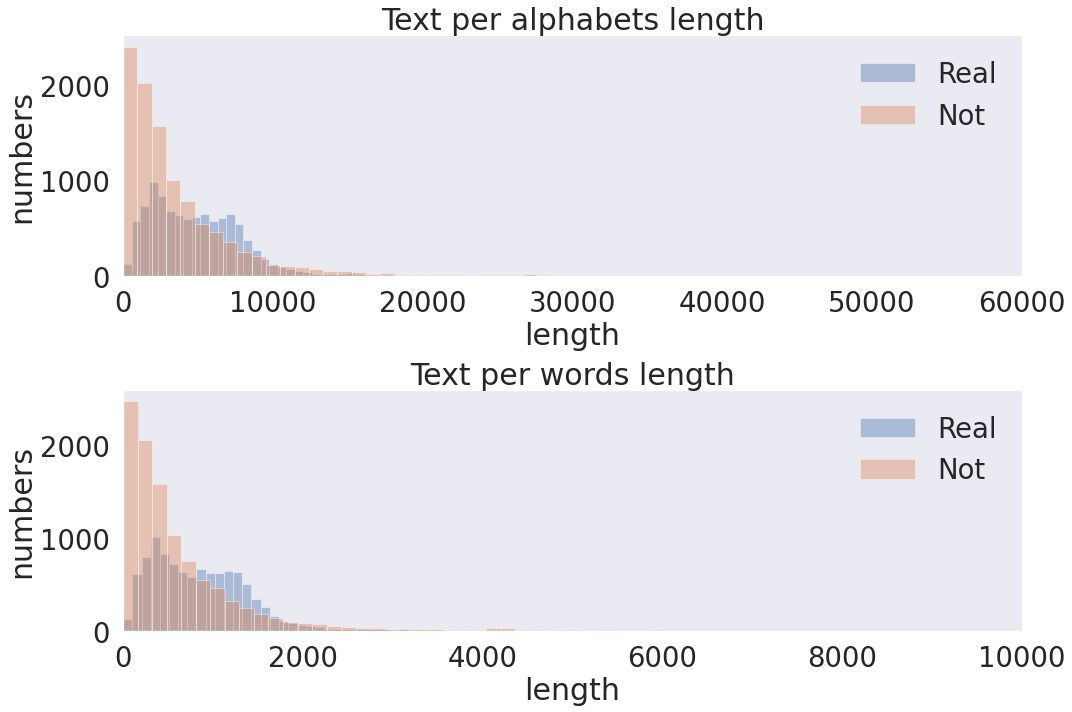

In [16]:
f, ax = plt.subplots(2,1,figsize=(15,10))

ax[0].set_title('Text per alphabets length')
ax[0].hist(train_df[train_df['label'] == 0]['length_alphabets'], alpha = 0.4, bins=150, label = 'Real')
ax[0].hist(train_df[train_df['label'] == 1]['length_alphabets'], alpha = 0.4, bins=150, label = 'Not')
ax[0].set_xlabel('length')
ax[0].set_ylabel('numbers')
ax[0].legend(loc='upper right')
ax[0].set_xlim(0,60000)
ax[0].grid()

ax[1].set_title('Text per words length')
ax[1].hist(train_df[train_df['label'] == 0]['length_words'], alpha = 0.4, bins=150, label = 'Real')
ax[1].hist(train_df[train_df['label'] == 1]['length_words'], alpha = 0.4, bins=150, label = 'Not')
ax[1].set_xlabel('length')
ax[1].set_ylabel('numbers')
ax[1].legend(loc='upper right')
ax[1].set_xlim(0,10000)
ax[1].grid()

f.tight_layout()
plt.show()

# 4. Preprocessing Data
* Null value processing
* Drop columns

In [17]:
train_df[train_df['text'].isnull()].head()

,id,title,author,text,label,length_alphabets,length_words
142,142,Gorafi Magazine : Entretien exclusif avec Bara...,NaN,NaN,1,3,1
573,573,Le top des recherches Google passe en top des ...,NaN,NaN,1,3,1
1200,1200,La Corée du Nord annonce avoir envoyé un missi...,NaN,NaN,1,3,1
1911,1911,Grand-Prix du Brésil – Romain Grosjean obtient...,NaN,NaN,1,3,1
2148,2148,Gorafi Magazine: Barack Obama « Je vous ai déj...,NaN,NaN,1,3,1


In [18]:
train_df['text'].fillna("", inplace=True)
# test_df['text'].fillna("", inplace=True)

In [19]:
train_df[train_df['author'].isnull()].head()

,id,title,author,text,label,length_alphabets,length_words
6,6,Life: Life Of Luxury: Elton John’s 6 Favorite ...,NaN,Ever wonder how Britain’s most iconic pop pian...,1,2729,489
8,8,Excerpts From a Draft Script for Donald Trump’...,NaN,Donald J. Trump is scheduled to make a highly ...,0,8177,1452
20,20,News: Hope For The GOP: A Nude Paul Ryan Has J...,NaN,Email \nSince Donald Trump entered the electio...,1,2231,377
23,23,Massachusetts Cop’s Wife Busted for Pinning Fa...,NaN,Massachusetts Cop’s Wife Busted for Pinning Fa...,1,2801,486
31,31,Israel is Becoming Pivotal to China’s Mid-East...,NaN,Country: Israel While China is silently playin...,1,7050,1146


In [20]:
train_df['author'] = train_df['author'].fillna('unknown')
# test_df['author'] = test_df['author'].fillna('unknown')

In [21]:
train_df[train_df['title'].isnull()].head()

,id,title,author,text,label,length_alphabets,length_words
53,53,NaN,Dairy✓ᵀᴿᵁᴹᴾ,Sounds like he has our president pegged. What ...,1,679,131
120,120,NaN,Anonymous,"Same people all the time , i dont know how you...",1,135,16
124,124,NaN,SeekSearchDestory,"You know, outside of any morality arguments, i...",1,533,100
140,140,NaN,Anonymous,There is a lot more than meets the eye to this...,1,736,120
196,196,NaN,Raffie,They got the heater turned up on high.,1,38,8


In [22]:
# Get average title size
train_df['title_size'] = train_df['title'].apply(lambda x: len(str(x)))

# If title size == 3("NAN") then change title size = 0
train_nan_index = train_df[train_df['title_size']==3].index
train_df['title_size'][train_nan_index] = 0 

train_avg_title_size = int(train_df.value_counts(['title_size']).mean())
print("train avg_title_size: ",train_avg_title_size)

train avg_title_size:  98


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [23]:
# # Get average title size
# test_df['title_size'] = test_df['title'].apply(lambda x: len(str(x)))

# # If title size == 3("NAN") then change title size = 0
# test_nan_index = test_df[test_df['title_size']==3].index
# test_df['title_size'][test_nan_index] = 0 

# test_avg_title_size = int(test_df.value_counts(['title_size']).mean())
# print("test avg_title_size: ",test_avg_title_size)

In [24]:
#change title "NAN" to text[:98]
train_df['title'][train_nan_index] = train_df['text'][train_nan_index].apply(lambda x: str(x)[:train_avg_title_size])

# test_df['title'][test_nan_index] = test_df['text'][test_nan_index].apply(lambda x: str(x)[:test_avg_title_size])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [25]:
train_df[train_df['id']==120]

,id,title,author,text,label,length_alphabets,length_words,title_size
120,120,"Same people all the time , i dont know how you...",Anonymous,"Same people all the time , i dont know how you...",1,135,16,0


In [26]:
train_df.head()

,id,title,author,text,label,length_alphabets,length_words,title_size
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,4930,820,81
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,4160,727,55
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,7692,1266,33
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,3237,559,63
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,938,154,93


In [27]:
train_df.isnull().sum()

id                  0
title               0
author              0
text                0
label               0
length_alphabets    0
length_words        0
title_size          0
dtype: int64

In [28]:
train_df.drop(['length_alphabets','length_words','title_size'], axis=1, inplace = True)
# test_df.drop(['title_size'], axis=1, inplace = True)

In [29]:
train_df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [30]:
# test_df.head()

# 5. Feature Engineering
* Concat "author" & "text" Columns
* Nomalization
* Plot WordClouds
* Words Tokenization
* Split Train / Test / Validation Data

In [31]:
train_df['text']= train_df['author'] + " " + train_df['text']
# test_df['text']= test_df['author'] + " " + test_df['text']

In [32]:
train_df.drop(['id','title','author'], axis=1, inplace=True)
# test_df.drop(['id','title','author'], axis=1, inplace=True)

In [33]:
train_df['text'][0]

'Darrell Lucus House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It By Darrell Lucus on October 30, 2016 Subscribe Jason Chaffetz on the stump in American Fork, Utah ( image courtesy Michael Jolley, available under a Creative Commons-BY license) \nWith apologies to Keith Olbermann, there is no doubt who the Worst Person in The World is this week–FBI Director James Comey. But according to a House Democratic aide, it looks like we also know who the second-worst person is as well. It turns out that when Comey sent his now-infamous letter announcing that the FBI was looking into emails that may be related to Hillary Clinton’s email server, the ranking Democrats on the relevant committees didn’t hear about it from Comey. They found out via a tweet from one of the Republican committee chairmen. \nAs we now know, Comey notified the Republican chairmen and Democratic ranking members of the House Intelligence, Judiciary, and Oversight committees that his agency was 

In [34]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')
lemmatizer = WordNetLemmatizer()

In [35]:
def preprocess(text,stem=False):
    text = text.lower()  # lowercase

    text = re.sub(r'[!]+', '!', text)
    text = re.sub(r'[?]+', '?', text)
    text = re.sub(r'[.]+', '.', text)
    text = re.sub(r"'", "", text)
    text = re.sub('\s+', ' ', text).strip()  # Remove and double spaces
    text = re.sub(r'&amp;?', r'and', text)  # replace & -> and
    text = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", text)  # Remove URLs
    # remove some puncts (except . ! # ?)
    text = re.sub(r'[:"$%&\*+,-/:;<=>@\\^_`{|}~]+', '', text)
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'EMOJI', text)
    
    tokens = []
    for token in text.split():
        if token not in stop_words:
            tokens.append(lemmatizer.lemmatize(token))
    return " ".join(tokens)

In [36]:
train_df['text'] = train_df['text'].apply(lambda x: preprocess(x))
# test_df['text'] = test_df['text'].apply(lambda x: preprocess(x))

#### WordCloud
* Label == 0 Real News
* Label == 1 Fake News

In [37]:
# plt.figure(figsize = (10,10))
# wc = WordCloud(max_words = 2000, width = 1600, height = 800).generate(" ".join(train_df[train_df.label == 0].text))
# plt.axis('off')
# plt.title('Real News')
# plt.imshow(wc,interpolation = 'bilinear')

In [38]:
# plt.figure(figsize = (10,10))
# wc = WordCloud(max_words = 2000, width = 1600, height = 800).generate(" ".join(train_df[train_df.label == 1].text))
# plt.axis('off')
# plt.title('Fake News')
# plt.imshow(wc,interpolation = 'bilinear')

In [39]:
x_train = train_df['text']
y_train = train_df['label']

In [40]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)

In [64]:
type(y_train)

pandas.core.series.Series

In [65]:
type(train_df)

pandas.core.frame.DataFrame

In [66]:
type(x_train)

pandas.core.series.Series

In [41]:
# tokenizer = Tokenizer()
# tokenizer.fit_on_texts(x_train)

In [42]:
# word_index = tokenizer.word_index
# vocab_size = len(word_index) + 1
# print("Vocab size : ",vocab_size)

In [43]:
# print("x_val shape:", x_val.shape)
# print("y_val shape:", y_val.shape)

In [44]:
# print("x_train shape:", x_train.shape)
# print("y_train shape:", y_train.shape)
# print("First Train data squence info : ", x_train[0].shape)
# print(x_train[0])

In [45]:
# x_train = pad_sequences(
#     tokenizer.texts_to_sequences(x_train),
#     maxlen = 256)
# x_val = pad_sequences(
#     tokenizer.texts_to_sequences(x_val),
#     maxlen = 256)
# x_test = pad_sequences(
#     tokenizer.texts_to_sequences(test_df['text']),
#     maxlen = 256)

# 6. Modeling
* LSTM Modeling
* Bert Modeling

In [46]:
# inputs = Input(shape=(256,), dtype='int32')

# embedding = tf.keras.layers.Embedding(vocab_size, 300)(inputs)
# net = SpatialDropout1D(0.2)(embedding)
# net = Bidirectional(LSTM(128,dropout=0.2, recurrent_dropout=0.2))(net)
# net = Dense(64,activation = 'relu')(net)
# net = Dropout(0.3)(net)
# net = Dense(1,activation = 'sigmoid')(net)

# outputs = net
# model = tf.keras.Model(inputs,outputs)

In [47]:
# model.summary()

In [48]:
# model.compile(optimizer = tf.keras.optimizers.Adam(),
#              loss = 'binary_crossentropy',
#              metrics = ['accuracy'])

In [49]:
# history = model.fit(
#     x_train,
#     y_train,
#     batch_size=1024, 
#     epochs=10,
#     validation_data=(x_val, y_val)
# )

In [50]:
# f,ax = plt.subplots(2,1,figsize=(20,15))

# ax[0].plot(history.history['accuracy'])
# ax[0].plot(history.history['val_accuracy'])
# ax[0].set_title('Model Accuracy')
# ax[0].set_ylabel('Accuracy')
# ax[0].set_xlabel('Epochs')
# ax[0].legend(['LSTM_train', 'LSTM_val'], loc='upper left')


# ax[1].plot(history.history['loss'])
# ax[1].plot(history.history['val_loss'])
# ax[1].set_title('Model Loss')
# ax[1].set_ylabel('Loss')
# ax[1].set_xlabel('Epochs')
# ax[1].legend(['train', 'val'], loc = 'upper left')

# f.tight_layout()
# plt.show()

### - BERT Modeling

In [51]:
!pip install --quiet transformers
from transformers import TFBertModel, BertTokenizer

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [59]:
#get BERT layer
bert_layers = TFBertModel.from_pretrained('bert-base-uncased')

#get BERT tokenizer
bert_tokenizer = BertTokenizer.from_pretrained("bert-large-uncased")

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [53]:
# !pip freeze > requirements.txt

In [54]:
encode = bert_tokenizer.encode("Hi nice meet you !")
decode = bert_tokenizer.decode(encode)

print("Encode: ", encode)
print("Decode: ", decode)

Encode:  [101, 7632, 3835, 3113, 2017, 999, 102]
Decode:  [CLS] hi nice meet you! [SEP]


In [61]:
# def bert_encode(data, max_len) :
#     input_ids = [] 
#     attention_masks = []
    
#     for i in range(len(data)):
#         encoded = bert_tokenizer.encode_plus(data[i],
#                                         add_special_tokens=True,
#                                         max_length=max_len,
#                                         pad_to_max_length=True,
#                                         return_attention_mask=True)
        
#         input_ids.append(encoded['input_ids'])
#         attention_masks.append(encoded['attention_mask'])
        
#     return np.array(input_ids),np.array(attention_masks)

In [83]:
def bert_encode(data, max_len):
    input_ids = [] 
    attention_masks = []
    
    # Ensure data is accessed as a list
    data = data.tolist()  # Convert Series to a list if it's a Pandas Series
    
    for text in data:
        encoded = bert_tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_len,
            truncation=True,  # Explicit truncation
            padding='max_length',  # Explicit padding
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
        
    return np.array(input_ids), np.array(attention_masks)


In [57]:
# train_df.to_csv("train_cleaned.csv")

In [67]:
# Original data
# x_train = train_df['text']
# y_train = train_df['label']

# # Split data into training (80%) and validation (20%)
# x_train_bert, x_val_bert, y_train_bert, y_val_bert = train_test_split(
#     x_train, y_train, test_size=0.2, random_state=42
# )


In [84]:
train_bert, val_bert = train_test_split(
    train_df, test_size=0.2, random_state=42
)

In [86]:
# type(train_bert)

In [90]:
x_train_bert = train_bert['text']
y_train_bert = train_bert['label']

In [96]:
print(x_train_bert.shape)
print(y_train_bert.shape)

(16640,)
(16640,)


In [97]:
# print(train_df['text'].shape)
# print(train_df['label'].shape)

(20800,)
(20800,)


In [88]:
# x_train_bert = train_df['text']
# y_train_bert = train_df['label']

# x_train_bert = x_train
# y_train_bert = y_train

# train_input_ids, train_attention_masks = bert_encode(x_train_bert,60)

In [89]:
# type(x_train_bert)

pandas.core.series.Series

In [92]:
train_input_ids, train_attention_masks = bert_encode(x_train_bert,60)

In [ ]:
# np.save('x_train_bert.npy', x_train_bert)
# np.save('y_train_bert.npy', y_train_bert)

In [93]:
input_ids = tf.keras.Input(shape=(60,),dtype='int32',name='input_ids')
attention_masks = tf.keras.Input(shape=(60,),dtype='int32',name='attention_masks')

output = bert_layers([input_ids,attention_masks])
output = output[1]
net = tf.keras.layers.Dense(32,activation='relu')(output)
net = tf.keras.layers.Dropout(0.2)(net)
net = tf.keras.layers.Dense(1,activation='sigmoid')(net)
outputs = net

model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = outputs)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


In [94]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [95]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 60)]         0                                            
__________________________________________________________________________________________________
attention_masks (InputLayer)    [(None, 60)]         0                                            
__________________________________________________________________________________________________
tf_bert_model_1 (TFBertModel)   TFBaseModelOutputWit 109482240   input_ids[0][0]                  
                                                                 attention_masks[0][0]            
__________________________________________________________________________________________________
dense (Dense)                   (None, 32)           24608       tf_bert_model_1[0][1]        

In [99]:
history = model.fit(
    [train_input_ids, train_attention_masks],
    y_train_bert,
    validation_split=0.2, 
    epochs=3,
    batch_size=32)

Epoch 1/3
416/416 [==============================] - 98s 237ms/step - loss: 0.0196 - accuracy: 0.9954 - val_loss: 0.0545 - val_accuracy: 0.9838
Epoch 2/3
416/416 [==============================] - 98s 236ms/step - loss: 0.0111 - accuracy: 0.9967 - val_loss: 0.0531 - val_accuracy: 0.9886
Epoch 3/3
416/416 [==============================] - 98s 236ms/step - loss: 0.0096 - accuracy: 0.9966 - val_loss: 0.0835 - val_accuracy: 0.9811


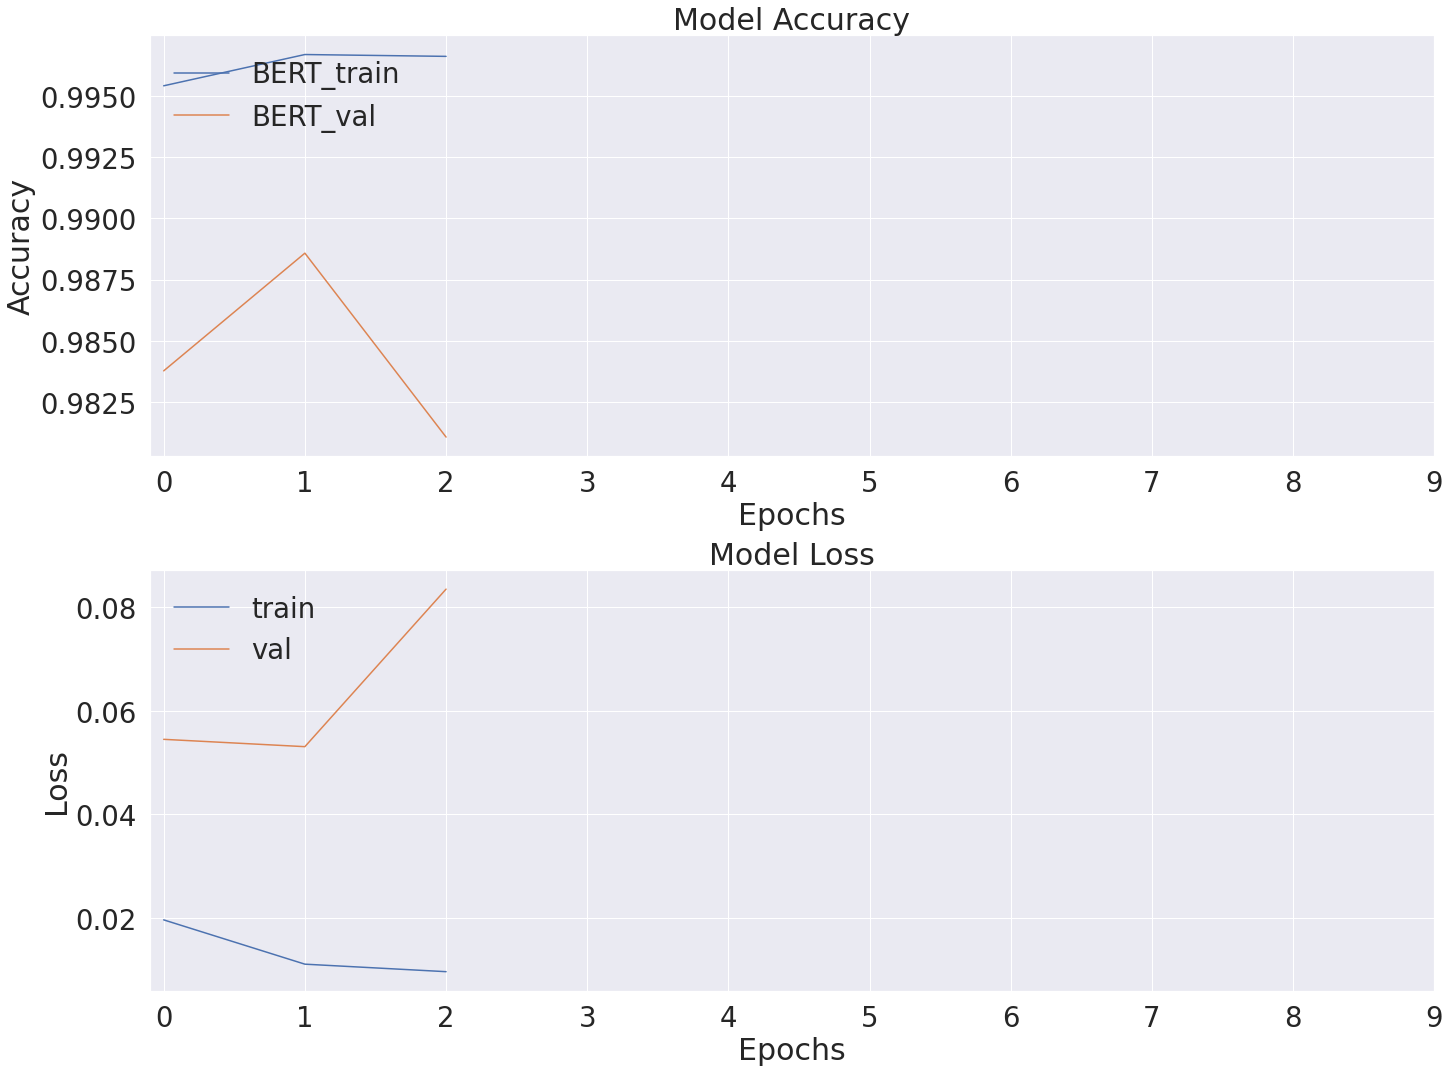

In [100]:
f,ax = plt.subplots(2,1,figsize=(20,15))

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Model Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_xticks([0,1,2,3,4,5,6,7,8,9])
ax[0].legend(['BERT_train', 'BERT_val'], loc='upper left')


ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_xticks([0,1,2,3,4,5,6,7,8,9])
ax[1].legend(['train', 'val'], loc = 'upper left')

f.tight_layout()
plt.savefig("bert.png")
plt.show()

In [ ]:
# from transformers import BertTokenizer, BertModel
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader

In [ ]:
# # Load the PyTorch BERT model and tokenizer
# bert_layers = BertModel.from_pretrained('bert-base-uncased')
# bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
# # Tokenization test
# encode = bert_tokenizer.encode("Hi nice meet you !")
# decode = bert_tokenizer.decode(encode)
# print("Encode: ", encode)
# print("Decode: ", decode)


In [ ]:
# # Dataset preparation
# class BertDataset(Dataset):
#     def __init__(self, texts, labels, tokenizer, max_len):
#         self.texts = texts
#         self.labels = labels
#         self.tokenizer = tokenizer
#         self.max_len = max_len

#     def __len__(self):
#         return len(self.texts)

#     def __getitem__(self, idx):
#         text = self.texts[idx]
#         label = self.labels[idx]
#         encoding = self.tokenizer.encode_plus(
#             text,
#             add_special_tokens=True,
#             max_length=self.max_len,
#             padding='max_length',
#             truncation=True,
#             return_attention_mask=True,
#             return_tensors='pt'
#         )
#         return {
#             'input_ids': encoding['input_ids'].squeeze(0),
#             'attention_mask': encoding['attention_mask'].squeeze(0),
#             'label': torch.tensor(label, dtype=torch.float)
#         }

# # Define the PyTorch model
# class BertClassifier(nn.Module):
#     def __init__(self, bert, hidden_size=32, dropout_rate=0.2):
#         super(BertClassifier, self).__init__()
#         self.bert = bert
#         self.dropout = nn.Dropout(dropout_rate)
#         self.fc1 = nn.Linear(bert.config.hidden_size, hidden_size)
#         self.fc2 = nn.Linear(hidden_size, 1)
#         self.relu = nn.ReLU()
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, input_ids, attention_mask):
#         outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
#         pooled_output = outputs.pooler_output  # Extract the pooled output
#         x = self.dropout(pooled_output)
#         x = self.relu(self.fc1(x))
#         x = self.dropout(x)
#         x = self.sigmoid(self.fc2(x))
#         return x

In [ ]:
# # Dataset and DataLoader
# max_len = 60
# batch_size = 32

# dataset = BertDataset(train_df['text'].tolist(), train_df['label'].tolist(), bert_tokenizer, max_len)
# data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# # Initialize model, optimizer, and loss function
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = BertClassifier(bert_layers).to(device)
# optimizer = optim.Adam(model.parameters(), lr=1e-5)
# criterion = nn.BCELoss()

In [ ]:
# # Training loop
# epochs = 10
# for epoch in range(epochs):
#     model.train()
#     total_loss = 0
#     for batch in train_loader:
#         input_ids = batch['input_ids'].to(device)
#         attention_mask = batch['attention_mask'].to(device)
#         labels = batch['label'].to(device).unsqueeze(1)  # Reshape for BCELoss

#         # Forward pass
#         outputs = model(input_ids, attention_mask)
#         loss = criterion(outputs, labels)

#         # Backward pass
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         total_loss += loss.item()

#     avg_loss = total_loss / len(train_loader)
#     print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}")

# 7. Submission
* Submit the predictions

In [ ]:
# submission = pd.read_csv('/kaggle/input/fake-news/submit.csv')
# submission.shape

In [ ]:
# submission.head()

In [ ]:
# test_df.head()

In [101]:
bert_x_test = val_bert['text']
bert_y_test = val_bert['label']

In [102]:
test_input_ids, test_attention_masks = bert_encode(bert_x_test,60)

In [103]:
pred = model.predict([test_input_ids,test_attention_masks])

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


In [104]:
from sklearn.metrics import f1_score

In [107]:
# Convert probabilities to binary labels
threshold = 0.5
y_pred_labels = (pred > threshold).astype(int)

# Calculate the F1 score
f1 = f1_score(bert_y_test, y_pred_labels)

print("F1 Score:", f1)

F1 Score: 0.9789368104312939


In [108]:
from sklearn.metrics import confusion_matrix



# Generate confusion matrix
conf_matrix = confusion_matrix(bert_y_test, y_pred_labels)

print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[2124    8]
 [  76 1952]]


In [ ]:
# pred[:5]

In [ ]:
# submission['label'] = (pred>0.5).astype(int)

In [ ]:
# submission.head()

In [ ]:
# submission.to_csv('submission.csv', index=False)

##### reference
* https://www.kaggle.com/mnavaidd/tweet-classification-using-lstm-bert/notebook?select=glove.6B.zip
* https://www.kaggle.com/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert

###  If this notebook is useful for your kaggling, "UPVOTE" for it 👀
#### THX to Reading My Notebook🌈